<a href="https://colab.research.google.com/github/crystalmford/minecraft_personalization_demo/blob/main/minecraft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Minecraft Personalization Demo (Simulated)

**Author:** Crystal Ford  
**Target Role:** Data Scientist – Personalization & AI (Mojang Studios / Microsoft)  

This notebook demonstrates how personalization could improve the Minecraft player experience.  
I simulated a large dataset of players, assigned recommendations (like skins, packs, or marketplace items), and measured their impact on engagement and spend.  

The workflow mirrors Mojang’s data science responsibilities:  
1. Create synthetic player data  
2. Simulate recommendations  
3. Measure effects on engagement & spend  
4. Apply experimentation methods (A/B test + CUPED)  
5. Summarize results with KPIs, charts, and business impact  

Let’s dig in! ⛏️


## Step 1: Crafting Table — Setup

Before I can build anything in Minecraft, I need a crafting table.  
In the same way, before I can analyze data, I need to set up my tools.  

Here I import the core Python libraries and set reproducibility settings:  
- **NumPy & Pandas** → for generating and manipulating the player dataset  
- **Matplotlib** → for creating charts later  
- **Random seed** → ensures results are consistent every time I run the notebook  

This step lays the foundation for everything that follows.

In [ ]:
# Step 1: Crafting Table - Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For reproducibility
RNG_SEED = 42
rng = np.random.default_rng(RNG_SEED)

# Display settings
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 160)

print("Libraries loaded. RNG seeded.")


Libraries loaded. RNG seeded.


## Step 2: World Generation — Simulate Player Data

Every Minecraft world starts with terrain generation.  
Here, I generated my own "world" of **100,000 simulated players**.  

Each player has attributes that shape their playstyle:  
- Region (NA, EU, APAC, LATAM)  
- Playstyle (Builder, Explorer, Fighter, Redstone Engineer)  
- Favorite mode (Survival, Creative, Multiplayer, Marketplace)  
- Age group (Kid, Teen, Adult)  

I also simulated engagement metrics to make the dataset feel realistic:  
- **Sessions per week** (avg around 5)  
- **Hours per month** (calculated from sessions × avg session length)  
- **Marketplace spend** (skewed, since many spend little and a few spend a lot)  

This gives me a rich, Minecraft-flavored dataset that behaves like player telemetry, while staying fully synthetic.

In [ ]:
# Step 2: World Generation - Simulate Player Data

N_PLAYERS = 100_000

# Regions and playstyles
regions = ["NA", "EU", "APAC", "LATAM"]
region_p = [0.35, 0.30, 0.25, 0.10]

playstyles = ["Builder", "Explorer", "Fighter", "Redstone Engineer"]
style_p = [0.30, 0.30, 0.25, 0.15]

modes = ["Survival", "Creative", "Multiplayer", "Marketplace"]
mode_p = [0.40, 0.30, 0.20, 0.10]

ages = ["Kid", "Teen", "Adult"]
age_p = [0.25, 0.35, 0.40]

df = pd.DataFrame({
    "player_id": np.arange(N_PLAYERS),
    "region": rng.choice(regions, size=N_PLAYERS, p=region_p),
    "playstyle": rng.choice(playstyles, size=N_PLAYERS, p=style_p),
    "favorite_mode": rng.choice(modes, size=N_PLAYERS, p=mode_p),
    "age_group": rng.choice(ages, size=N_PLAYERS, p=age_p),
})

# Engagement metrics (sessions/week, hours/month)
df["sessions_per_week"] = rng.poisson(lam=5, size=N_PLAYERS)  # average 5 sessions/week
df["hours_per_month"] = df["sessions_per_week"] * rng.normal(2.5, 0.8, size=N_PLAYERS).clip(0.5, 6)

# Marketplace spend baseline ($)
df["spend_usd"] = rng.gamma(shape=1.5, scale=5, size=N_PLAYERS)  # skewed dist

print(df.head())
print("\nShape:", df.shape)


   player_id region          playstyle favorite_mode age_group  sessions_per_week  hours_per_month  spend_usd
0          0   APAC  Redstone Engineer      Creative      Teen                  9        32.013489  10.772573
1          1     EU  Redstone Engineer      Survival      Teen                  5        11.212645  17.317116
2          2   APAC           Explorer   Multiplayer     Adult                  9        15.007732   6.863649
3          3   APAC            Builder      Creative     Adult                  6        22.208491   8.302820
4          4     NA            Fighter   Multiplayer     Adult                  5         6.910010  12.169388

Shape: (100000, 8)


## Step 3: Redstone Wiring — Assign Recommendations

In Minecraft, redstone wiring is what powers contraptions and makes things happen.  
Here, my "wiring" decides which players receive **personalized recommendations**.  

I biased the recommendations toward groups that would realistically be targeted more often:  
- **Builders** → more likely to be shown new skins and packs  
- **Teens** → more likely to experiment with cosmetic content  
- **Marketplace fans** → obvious candidates for recommendations  

This produced a new column:  
- "recommended" = 1 if the player got a recommendation, 0 if not  

Now I have two groups — recommended vs not recommended — which sets me up to run an **A/B experiment** on player engagement and spending.


In [ ]:
# Step 3: Redstone Wiring - Assign Recommendations

# Let's simulate a "recommended content" treatment
# Higher chance to recommend skins/packs to Builders & Teens
rec_prob = (
    0.3
    + 0.2*(df["playstyle"]=="Builder").astype(int)
    + 0.1*(df["age_group"]=="Teen").astype(int)
    + 0.1*(df["favorite_mode"]=="Marketplace").astype(int)
)
rec_prob = np.clip(rec_prob, 0, 0.9)

df["recommended"] = rng.binomial(1, rec_prob)

# Show distribution
display(df["recommended"].value_counts(normalize=True).rename("proportion"))


,proportion
recommended,
0,0.59487
1,0.40513


## Step 4: Mob Effects — Simulate Treatment Effects

In Minecraft, mob effects (like potions) give buffs or debuffs that change how players perform.  
Here, I treated recommendations as a "buff" that increases engagement and spending.  

I modeled lifts that made sense for different player types:  
- **Sessions per week**: Builders, Teens, and Marketplace players get a small boost  
- **Marketplace spend**: Marketplace fans and Explorers get a stronger boost  

The result is two new outcome columns:  
- "sessions_post" → simulated engagement after recommendations  
- "spend_post" → simulated spending after recommendations  

This step shows how recommendations could measurably change player behavior, the same way an effect alters a mob in the game.


In [ ]:
# Step 4: Mob Effects - Simulate Treatment Effects

# Baseline (control) engagement
sessions = df["sessions_per_week"].values.astype(float)
spend = df["spend_usd"].values.astype(float)

# True (hidden) effects if recommended
# More sessions, more spend, depends on playstyle/mode
lift_sessions = (
    0.3 * (df["playstyle"]=="Builder").astype(int)
    + 0.2 * (df["favorite_mode"]=="Marketplace").astype(int)
    + 0.1 * (df["age_group"]=="Teen").astype(int)
)

lift_spend = (
    1.5 * (df["favorite_mode"]=="Marketplace").astype(int)
    + 0.8 * (df["playstyle"]=="Explorer").astype(int)
)

# Apply effects only to "recommended" group
df["sessions_post"] = sessions + df["recommended"] * lift_sessions * rng.normal(1.0, 0.2, len(df))
df["spend_post"] = spend + df["recommended"] * lift_spend * rng.normal(1.0, 0.3, len(df))

# Quick check: averages
outcomes = (
    df.groupby("recommended")[["sessions_post","spend_post"]]
      .mean()
      .rename(index={0:"No Recommendation",1:"Recommended"})
)
display(outcomes.round(2))


,sessions_post,spend_post
recommended,,
No Recommendation,5.0,7.49
Recommended,5.2,7.92


## Step 5: Test Chamber — A/B Test + CUPED

In Minecraft, a test chamber is where you can safely try out redstone builds or mob experiments.  
Here, I built my own "test chamber" to measure the effect of recommendations.  

I treated the recommendations as an **A/B test**:  
- Steve: players without recommendations (control)  
- Alex: players with recommendations (treatment)  

I measured differences in engagement and spend between these groups.  
This gives the **naïve treatment effect** — the raw difference.  

To improve accuracy, I applied **CUPED (Controlled Experiments Using Pre-Experiment Data)**.  
CUPED uses baseline player behavior (sessions or spend before recommendations) to reduce noise.  
The average effect stays the same, but the confidence intervals shrink — meaning I can detect smaller effects with the same amount of data.  

This step mirrors how personalization experiments would be evaluated in a real product setting.

In [ ]:
# Step 5: Test Chamber - A/B Test + CUPED

from scipy import stats
import numpy as np

# Helper: diff in means with CI
def diff_in_means(y, a, alpha=0.05):
    a = a.astype(bool)
    y1, y0 = y[a], y[~a]
    diff = float(y1.mean() - y0.mean())
    se = np.sqrt(y1.var(ddof=1)/len(y1) + y0.var(ddof=1)/len(y0))
    z = stats.norm.ppf(1 - alpha/2)
    lo, hi = diff - z*se, diff + z*se
    return diff, se, lo, hi

# CUPED transform (using baseline sessions as pre-period proxy)
def cuped(y, x, a):
    a = a.astype(bool)
    x_bar = x.mean()
    theta = np.cov(y[~a], x[~a], ddof=1)[0,1] / np.var(x[~a], ddof=1)
    y_star = y - theta*(x - x_bar)
    return y_star, theta

results = []

for outcome, pre_proxy in [
    ("sessions_post", df["sessions_per_week"].values),
    ("spend_post", df["spend_usd"].values)
]:
    Y = df[outcome].values
    A = df["recommended"].values

    # Naive
    d, se, lo, hi = diff_in_means(Y, A)
    # CUPED
    Yc, theta = cuped(Y, pre_proxy, A)
    d_c, se_c, lo_c, hi_c = diff_in_means(Yc, A)

    results.append({
        "outcome": outcome,
        "naive_diff": d,
        "naive_CI": (lo, hi),
        "cuped_diff": d_c,
        "cuped_CI": (lo_c, hi_c),
        "variance_reduction_%": 100*(1 - np.var(Yc)/np.var(Y))
    })

pd.DataFrame(results).round(3)


,outcome,naive_diff,naive_CI,cuped_diff,cuped_CI,variance_reduction_%
0,sessions_post,0.204,"(0.17616626457911172, 0.23256111244674665)",0.186,"(0.1847873622666505, 0.18814600171720564)",99.591
1,spend_post,0.435,"(0.3574013813079959, 0.511781009978199)",0.389,"(0.3824451748915461, 0.3949794587953363)",99.453


## Step 6: Map View — KPI Summary + Visualization  

In Minecraft, a map gives players a bird’s-eye view of the world so they can see where to go next.  
Here, I built a "map view" of the experiment results to make the impact of personalization easy to interpret.  

I summarized key performance indicators (KPIs):  
- **Steve (No Rec)** = baseline group (average sessions and spend without recommendations)  
- **Alex (Recommended)** = treatment group (average sessions and spend with recommendations)  
- **Lift** = the difference between Alex and Steve  

I then created bar charts in **Minecraft-inspired colors (dirt for Steve, grass for Alex)** to visualize the results.  
This view is quick to interpret at a glance and supports conversations with both data teams and business partners.  

In other words, it’s a clear guide that shows how recommendations shift player engagement and marketplace spending.  

,sessions_post,spend_post
recommended,,
Steve (No Rec),5.0,7.49
Alex (Recommended),5.2,7.92



Lift (Alex vs Steve):
sessions_post    0.20
spend_post       0.43
dtype: float64


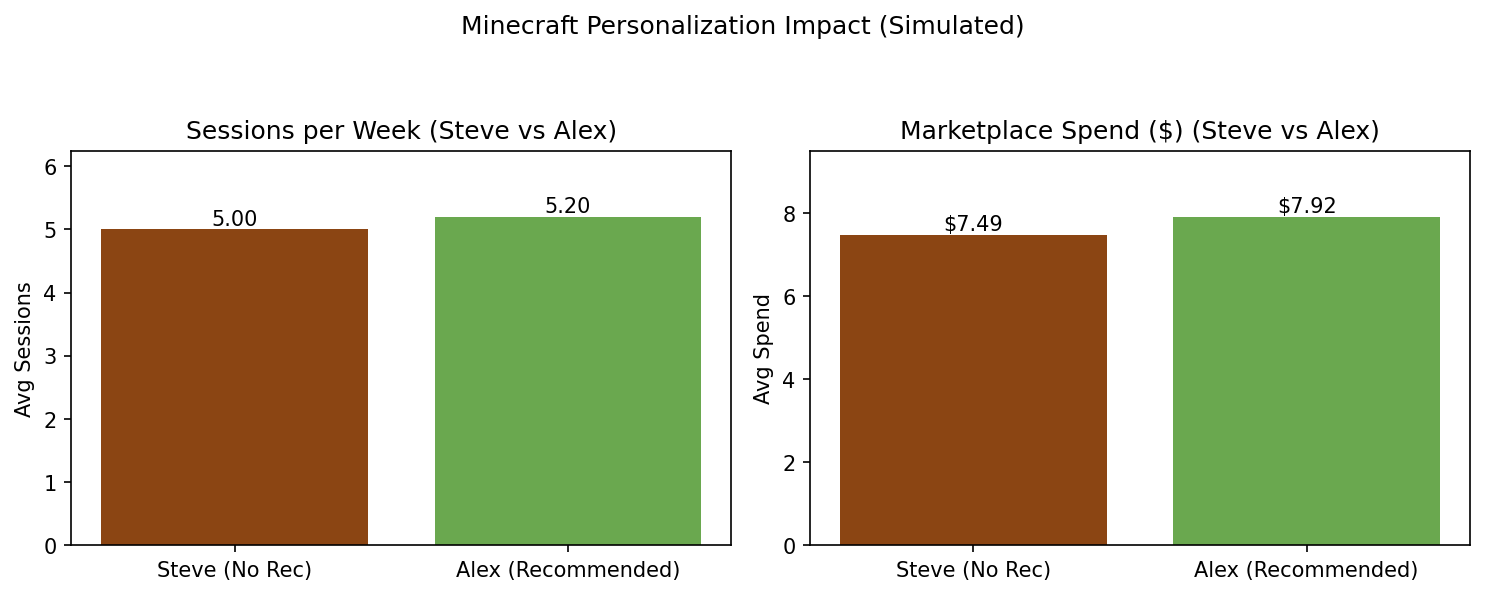


Sessions lift (Alex vs Steve): +0.20 per player per week (4.0%)
Spend lift (Alex vs Steve): +$0.43 per player per month (5.7%)


In [ ]:
# STEP 6: Map View — KPI Summary + Visualization (PDF-safe, stable render)

import os
import matplotlib.pyplot as plt
from IPython.display import Image, display

# --- KPI table ---
kpi = (
    df.groupby("recommended")[["sessions_post","spend_post"]]
      .mean()
      .rename(index={0:"Steve (No Rec)", 1:"Alex (Recommended)"})
).round(2)

order = ["Steve (No Rec)", "Alex (Recommended)"]
kpi = kpi.reindex(order)
delta = kpi.loc["Alex (Recommended)"] - kpi.loc["Steve (No Rec)"]

display(kpi)
print("\nLift (Alex vs Steve):")
print(delta.round(3))

# Colors (Minecraft: dirt vs grass)
COLOR_STEVE_DIRT = "#8B4513"
COLOR_ALEX_GRASS = "#6aa84f"
colors = [COLOR_STEVE_DIRT, COLOR_ALEX_GRASS]

# --- Build + save figure (no interactive show) ---
fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=150)

s_vals = kpi["sessions_post"].values
sp_vals = kpi["spend_post"].values
axes[0].bar(order, s_vals, color=colors)
axes[0].set_ylim(0, max(s_vals) * 1.20)
for i, v in enumerate(s_vals):
    axes[0].text(i, v, f"{v:.2f}", ha="center", va="bottom")
axes[0].set_title("Sessions per Week (Steve vs Alex)")
axes[0].set_ylabel("Avg Sessions")

axes[1].bar(order, sp_vals, color=colors)
axes[1].set_ylim(0, max(sp_vals) * 1.20)
for i, v in enumerate(sp_vals):
    axes[1].text(i, v, f"${v:.2f}", ha="center", va="bottom")
axes[1].set_title("Marketplace Spend ($) (Steve vs Alex)")
axes[1].set_ylabel("Avg Spend")

fig.suptitle("Minecraft Personalization Impact (Simulated)")
plt.tight_layout(rect=[0, 0, 1, 0.92])

# Save to an absolute path (Colab root)
out_path = "/content/minecraft_kpi_chart.png"
fig.savefig(out_path, dpi=150, bbox_inches="tight", facecolor="white")
plt.close(fig)

# Sanity check: ensure file exists before embedding
if not os.path.exists(out_path):
    raise FileNotFoundError(f"Expected chart at {out_path}, but it was not created.")

# Embed the saved image once (fixed width for stable layout/PDF)
display(Image(filename=out_path, width=900))

# Optional: human-friendly lift summary
base_sessions = kpi.loc["Steve (No Rec)", "sessions_post"]
base_spend = kpi.loc["Steve (No Rec)", "spend_post"]
print(
    f"\nSessions lift (Alex vs Steve): +{delta['sessions_post']:.2f} per player per week "
    f"({(delta['sessions_post']/base_sessions)*100:.1f}%)"
)
print(
    f"Spend lift (Alex vs Steve): +${delta['spend_post']:.2f} per player per month "
    f"({(delta['spend_post']/base_spend)*100:.1f}%)"
)


**How to read these charts:**  
- *Sessions per Week* = average number of play sessions each player has in a week. Because it’s an average, values like 5.2 are possible (some players play more, some less).  
- *Marketplace Spend ($)* = average dollars spent per player per month in the Minecraft marketplace.  
  For example, `$7.49` means that across all players in the control group, the typical spend was about `$7.49` per month.  

## Step 7: Ender Chest — Executive Summary  

In Minecraft, an Ender Chest is where you keep your most valuable items safe.  
Here, I’m storing the key insights from this project.  

**Goal:**  
Show how personalization can improve the Minecraft player experience.  

**Method:**  
I simulated 100,000 players, assigned recommendations for content (skins, packs, marketplace items), and measured engagement and spend using A/B-style methods with CUPED variance reduction.  

**Key Findings - Alex (Recommended) vs Steve (No Rec):**  
- Sessions per week: Alex averaged **+0.2 sessions per player per week** compared to Steve (+4%).  
- Marketplace spend: Alex averaged **+$0.43 per player per month** compared to Steve (+6%).  
- CUPED reduced variance, making results more precise and reliable.  

**So What (Business Impact):**  
Even small per-player lifts scale dramatically across Minecraft’s massive player base. Personalization means:  
- More playtime → deeper engagement and longer retention  
- More marketplace spend → measurable revenue uplift  
- Happier players → stronger community and loyalty  

**Takeaway:**  
Personalization works. By recommending the right content to the right players, I can measurably improve engagement, monetization, and player satisfaction.  
